# Final Project: Fake Reviews Detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [2]:
reviews_df = pd.read_csv('fake_reviews_dataset.csv')

In [3]:
reviews_df.head()

,category,rating,text,label
0,Home_and_Kitchen,5.0,"Love this! Well made, sturdy, and very comfor...",1
1,Home_and_Kitchen,5.0,"love it, a great upgrade from the original. I...",1
2,Home_and_Kitchen,5.0,This pillow saved my back. I love the look and...,1
3,Home_and_Kitchen,1.0,"Missing information on how to use it, but it i...",1
4,Home_and_Kitchen,5.0,Very nice set. Good quality. We have had the s...,1


In [4]:
reviews_df['label'].value_counts()

label
1    20294
0    20232
Name: count, dtype: int64

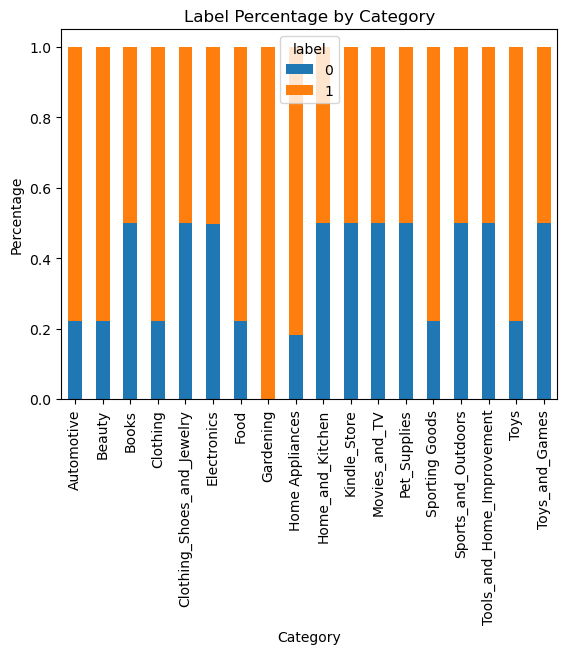

In [5]:
#Get label percentage by category
reviews_df.groupby('category')['label'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
plt.title('Label Percentage by Category')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.show()

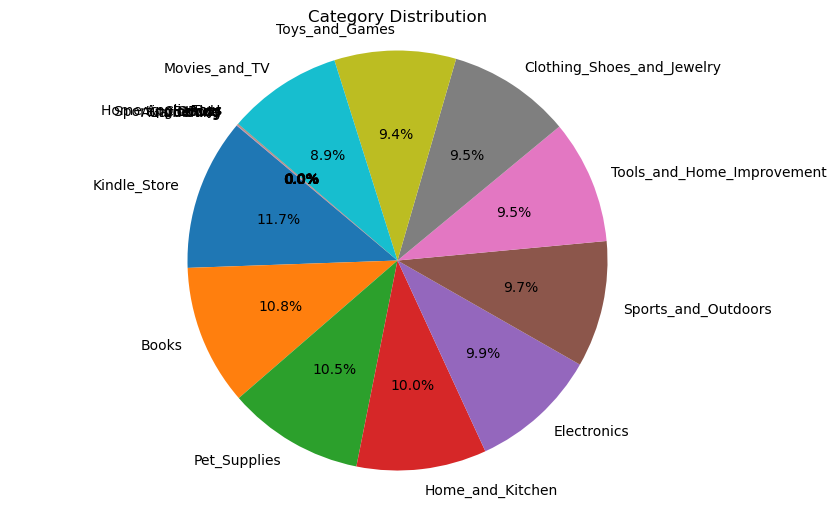

In [12]:
#Pie chart of category distribution
category_counts = reviews_df['category'].value_counts()
plt.figure(figsize=(10, 6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Category Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

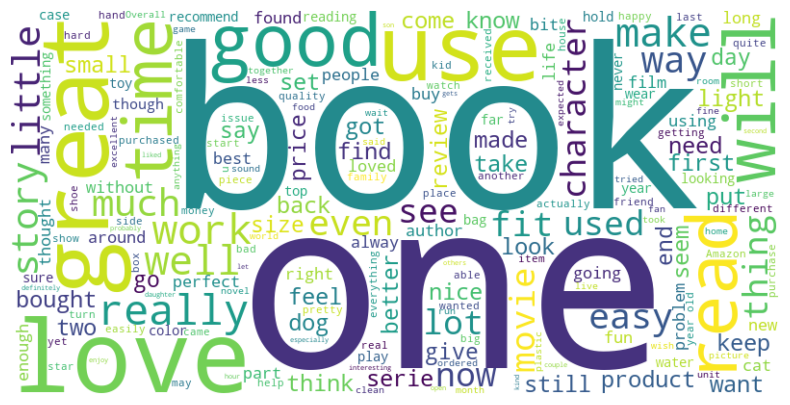

In [ ]:
#Create Word Cloud for label = 0
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = " ".join(reviews_df[reviews_df['label'] == 0]['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

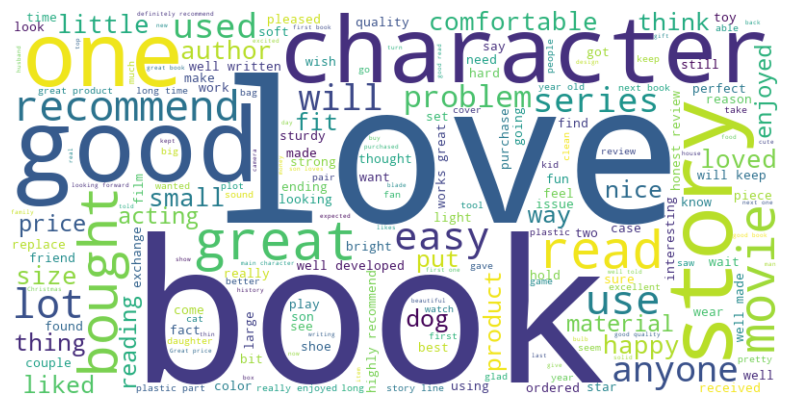

In [10]:
#Create Word Cloud for label = 1
from wordcloud import WordCloud
from matplotlib import pyplot as plt

text = " ".join(reviews_df[reviews_df['label'] == 1]['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Notes:
- character is more significant for fake
- time not used much by fake


# Build Fake Review Detector

## Random Forest Classifier

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [14]:
X = reviews_df['text']
y = reviews_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
rf_classifier = RandomForestClassifier(
    n_estimators=100, 
    random_state=42)
rf_classifier.fit(X_train_vec, y_train)

#Predict using classifier
y_pred = rf_classifier.predict(X_test_vec)

#Print classification report
print(classification_report(y_test, y_pred))
#Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.86      0.82      0.84      4031
           1       0.83      0.86      0.85      4075

    accuracy                           0.84      8106
   macro avg       0.84      0.84      0.84      8106
weighted avg       0.84      0.84      0.84      8106



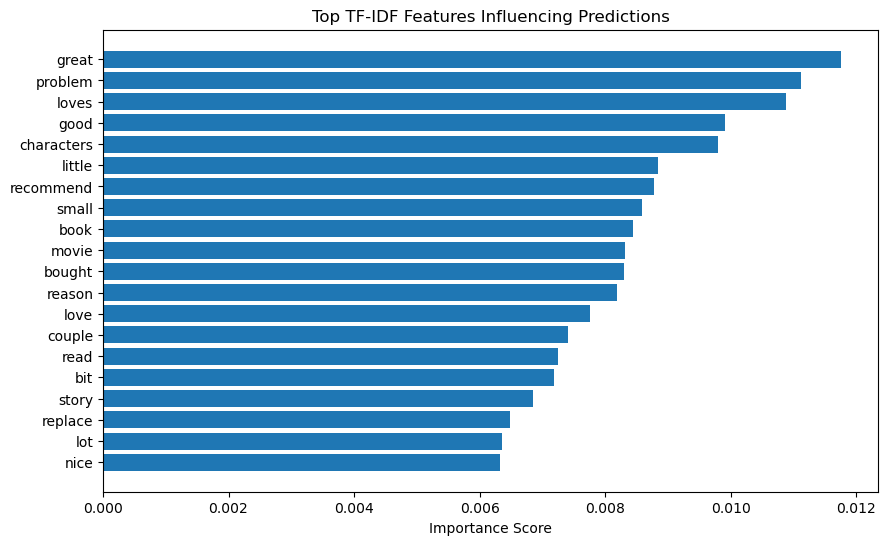

In [17]:
import matplotlib.pyplot as plt

# Get feature importances
importances = rf_classifier.feature_importances_

# Get feature names from vectorizer
feature_names = vectorizer.get_feature_names_out()

# Pair names with importances and sort
feature_importance = sorted(zip(importances, feature_names), reverse=True)

# Top N for visualization
top_n_features = feature_importance[:20]
words = [name for _, name in top_n_features]
scores = [score for score, _ in top_n_features]

plt.figure(figsize=(10, 6))
plt.barh(words[::-1], scores[::-1])
plt.xlabel("Importance Score")
plt.title("Top TF-IDF Features Influencing Predictions")
plt.show()


## Random Forest with RandomSearch

In [19]:
#Import randomsearchcv
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [20]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('rf', RandomForestClassifier(random_state=42))
])

In [25]:
param_dist = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'tfidf__max_df': [0.5, 0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)]
}

In [28]:
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='f1',
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words='english')),
                                             ('rf',
                                              RandomForestClassifier(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'rf__max_depth': [None, 10, 20, 30],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [50, 100, 200],
                                        'tfidf__max_df': [0.5, 0.75, 1.0],
                                        'tfidf__ngram_range': [(1, 1), (1, 2),
                                                               (1, 3)]},
                   random_state=42, scoring='f1', verbose=2)

In [29]:
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)


Best parameters: {'tfidf__ngram_range': (1, 1), 'tfidf__max_df': 0.75, 'rf__n_estimators': 50, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 1, 'rf__max_depth': None}
Best score: 0.8421270081835909


In [30]:
y_pred = random_search.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      4031
           1       0.83      0.89      0.86      4075

    accuracy                           0.85      8106
   macro avg       0.85      0.85      0.85      8106
weighted avg       0.85      0.85      0.85      8106

[[3282  749]
 [ 468 3607]]


## XGBoost with RandomSearchCV

In [31]:
from xgboost import XGBClassifier

In [35]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('xgb', XGBClassifier(random_state=42))
])

In [42]:
param_dist = {
    'xgb__n_estimators': [300, 500],
    'xgb__max_depth': [5, 7],
    'xgb__learning_rate': [0.1, 0.2],
    'xgb__subsample': [0.7, 0.85],
    'tfidf__max_df': [0.5, 0.75]
}

In [43]:
random_search_xgb = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    verbose=1,
    n_jobs=-1
)

random_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(stop_words='english')),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            device=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                                            gamma=None,
                                                            grow_poli...
                                                            max_leaves=None,
                                                            min_child_weight=None,
                                                            missing=nan,
                                                            monotone_constraints=None,
                                                            multi_strategy=None,
                                                            n_estimators=None,
                                                            n_jobs=None,
                                                            num_parallel_tree=None,
                                                            random_state=42, ...))]),
                   n_jobs=-1,
                   param_distributions={'tfidf__max_df': [0.5, 0.75],
                                        'xgb__learning_rate': [0.1, 0.2],
                                        'xgb__max_depth': [5, 7],
                                        'xgb__n_estimators': [300, 500],
                                        'xgb__subsample': [0.7, 0.85]},
                   verbose=1)

In [44]:
print(random_search_xgb.best_params_)
print(random_search_xgb.best_score_)

{'xgb__subsample': 0.7, 'xgb__n_estimators': 300, 'xgb__max_depth': 7, 'xgb__learning_rate': 0.2, 'tfidf__max_df': 0.75}
0.853362122146823


In [45]:
y_pred = random_search_xgb.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      4031
           1       0.87      0.85      0.86      4075

    accuracy                           0.86      8106
   macro avg       0.86      0.86      0.86      8106
weighted avg       0.86      0.86      0.86      8106

[[3526  505]
 [ 615 3460]]
